In [1]:
# Notes: This code is inspired by Andrej Karpathy's video series on youtube. https://github.com/karpathy/micrograd/blob/master/micrograd/engine.py
# After watching the video once I am attempting to recreate the code from memory. Hopefully I can turn it into something usable as a fun project.
# - Aryan M

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MLUtils import loadingAnimation, printPurple, plot_function, displayPower
import random

In [65]:
# Value class
class Value:
    """
    Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects.
    
    Attributes:
        value (float): The value of the object
        grad (float): The gradient of the object
        _prev (set): The set of all the previous objects
        _operation (str): The operation that was used to get the value
        _backward (function): The function that is used to back propagate the gradient
        
    Operations:
        __add__: Adds two values together
        __mul__: Multiplies two values together
        __truediv__: Divides two values together
        __pow__: Raises a value to a power
        __neg__: Negates a value

    Back Propagation:
        backProp: Back propagates the gradient through the graph
    
    Activation Functions:
        relu: Applies the ReLU activation function
        tanh: Applies the Tanh activation function
        sigmoid: Applies the Sigmoid activation function
        
    Repr: 
        Returns Value({label}: Data: {value}, Grad: {grad})
    """
    
    def __init__(self, value, _children=(), _op = "", **kwargs):
        self.label = kwargs["label"] if "label" in kwargs else ""
        self.value = value
        self.grad = 0.0
        self._prev = set(_children)
        self._operation = _op
        self._backward = lambda: None
        
    # Arithmatic Operations
        
    def __add__(self, other) -> "Value":
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value + other.value, (self, other), "+")   # adds just the values of the Value data types
        
        def backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = backward
        
        return out
    
    def __mul__(self, other) -> "Value":
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value * other.value, (self, other), "*")
        
        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = backward
        return out
    
    def __truediv__(self, other) -> "Value":
        return self.__mul__(other**-1)
    
    def __pow__(self, other) -> "Value":
        assert isinstance(other, (int, float)), "Power must be a number"
        out = Value(self.value**other, (self,), displayPower(self.label if self.label != "" else "(" + str(round(self.value, 6)) + ")", other.label if isinstance(other, Value) and other.label != "" else str(other)))
        
        def backward():
            self.grad += (other * self.value**(other-1)) * out.grad
        out._backward = backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    # Reverse Arithmatic Operations
        
    def __radd__(self, other) -> "Value":
        return self.__add__(other)
    
    def __rmul__(self, other) -> "Value":
        return self.__mul__(other)
    
    def __rtruediv__(self, other) -> "Value":
        return self.__truediv__(other)
    
    def __rpow__(self, other) -> "Value":
        return self.__pow__(other)
    
    # Activation Functions
        
    def relu(self) -> "Value":
        out = Value(0 if self.value < 0 else self.value, (self,), "ReLU")
        
        def backward():
            self.grad += (out.value > 0) * out.grad
        out._backward = backward
        
        return out
    
    def tanh(self) -> "Value":
        out = Value(np.tanh(self.value), (self,), "Tanh")
        
        def backward():
            self.grad += (1 - out.value**2) * out.grad
        out._backward = backward
        
        return out
    
    def sigmoid(self) -> "Value":
        out = Value(1/(1+np.exp(-self.value)), (self,), "Sigmoid")
        
        def backward():
            self.grad += out.value * (1 - out.value) * out.grad
        out._backward = backward
        
        return out
        
    # Back Propagation
    
    def backProp(self) -> None: 
        topo = []
        visited = set()
        def build_topo(v):  # Dont really understand the topo map but need to dive into it further
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        return f'Value({self.label + ": " if self.label != "" else self.label}Data: {self.value}, Grad: {self.grad})' # Didnt even know you could add functions like that but glad I tried it

In [73]:
from graphviz import Digraph

class visualizer():
    def __init__(self, root, rankdir = 'LR'):
        self.root = root
        self.nodes, self.edges = self.trace()
        self.format = 'svg'
        self.rankdir = rankdir
    
    def trace(self):
            nodes, edges = set(), set()
            
            def build(current):
                if current not in nodes:
                    nodes.add(current)
                    for child in current._prev:
                        edges.add((child, current))
                        build(child)
            build(self.root)
            
            return nodes, edges
    
    def __call__(self):
        drawing = Digraph(format=self.format)
        drawing.attr(rankdir=self.rankdir)  # Set the rankdir attribute here
        
        for node in self.nodes:
            uid = str(id(node))
            label = "{%s | data %.4f | grad %.4f}" % (node.label, node.value, node.grad)
            drawing.node(name=uid, label=label, shape='record')
            
            if node._operation:
                drawing.node(name=uid + node._operation, label=node._operation)
                drawing.edge(uid + node._operation, uid)
                    
        for node1, node2 in self.edges:
            drawing.edge(str(id(node1)), str(id(node2)) + node2._operation)
        
        return drawing

In [78]:
class Neuron:
    def __init__(self, numInp, activation = relu):
        ''' numInp: number of inputs
            activation: activation function 
                Options: relu(default), sigmoid, tanh'''
        
        self.weights = [Value(random.uniform(-1,1)) for _ in range(numInp)]
        self.bias = Value(0)
        self.activation = activation


    def feedforward(self, inputs):
        total = np.dot(self.weights, inputs) + self.bias
        return total.relu()
    

neuron = Neuron(2)


NameError: name 'random' is not defined

In [61]:
printPurple("\nDockstring for Value Class: ")
print(Value.__doc__)                           # added docstring


Dockstring for Value Class: 

    Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects.
    
    Attributes:
        value (float): The value of the object
        grad (float): The gradient of the object
        _prev (set): The set of all the previous objects
        _operation (str): The operation that was used to get the value
        _backward (function): The function that is used to back propagate the gradient
        
    Operations:
        __add__: Adds two values together
        __mul__: Multiplies two values together
        __truediv__: Divides two values together
        __pow__: Raises a value to a power
        __neg__: Negates a value

    Back Propagation:
        backProp: Back propagates the gradient through the graph
    
    Activation Functions:
        relu: Applies the ReLU activation function
        tanh: Applies the Tanh activation function
        sigmoid: Applies the Sigmoid activation fun

In [71]:
# Testing the prototype for the Value class

x = Value(2.0)  ; x.label = 'x'
y = Value(0.38462)  ; y.label = 'y'
j = Value(3.0) ; j.label = 'j'

z = y **2   ; z.label = 'z'
f = ((z + x) / 34)  ; f.label = 'f'
h = f.tanh() ; h.label = 'h'


printPurple(f'\n{z}')
print("z Previous: " , z._prev)
printPurple(f)
print("f Previous: ", f._prev)       
printPurple(h)
print("h Previous: ", h._prev) # Added _prev to track children

printPurple("\nTesting radd and rmul:")
print(2.0 + x, "\t",x + 2.0)                    # Added radd
print(6.0 * x, "\t", x * 6.0)                   # Added rmul

h.backProp() # Dont call backProp far from


Value(z: Data: 0.1479325444, Grad: 0.0)
z Previous:  {Value(y: Data: 0.38462, Grad: 0.0)}
Value(f: Data: 0.06317448660000001, Grad: 0.0)
f Previous:  {Value(Data: 0.029411764705882353, Grad: 0.0), Value(Data: 2.1479325444, Grad: 0.0)}
Value(h: Data: 0.0630905770939617, Grad: 0.0)
h Previous:  {Value(f: Data: 0.06317448660000001, Grad: 0.0)}

Testing radd and rmul:
Value(Data: 4.0, Grad: 0.0) 	 Value(Data: 4.0, Grad: 0.0)
Value(Data: 12.0, Grad: 0.0) 	 Value(Data: 12.0, Grad: 0.0)
Value(Data: 0.029411764705882353, Grad: 0.0) 

Value(y: Data: 0.38462, Grad: 0.0) 

Value(z: Data: 0.1479325444, Grad: 0.0) 

Value(x: Data: 2.0, Grad: 0.0) 

Value(Data: 2.1479325444, Grad: 0.0) 

Value(f: Data: 0.06317448660000001, Grad: 0.0) 

Value(h: Data: 0.0630905770939617, Grad: 0.0) 



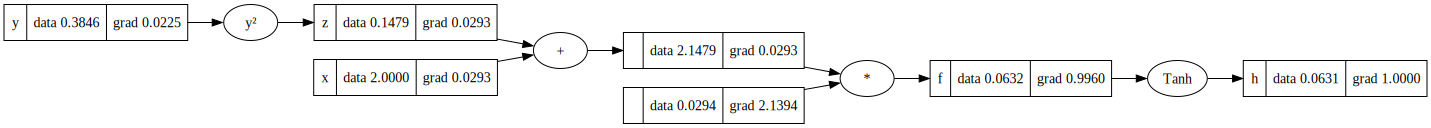

In [72]:
v = visualizer(h)
v() # I think this can be cleaner but I dont know how at the moment

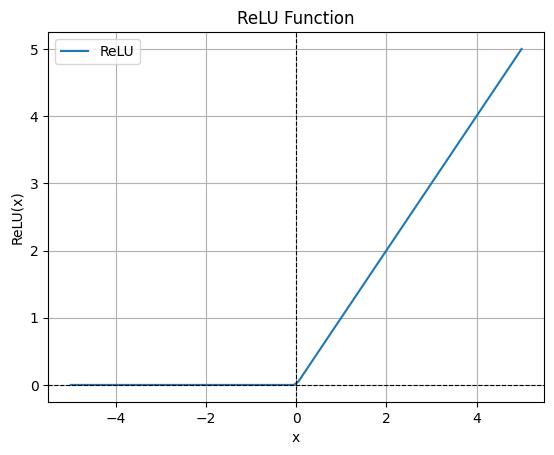

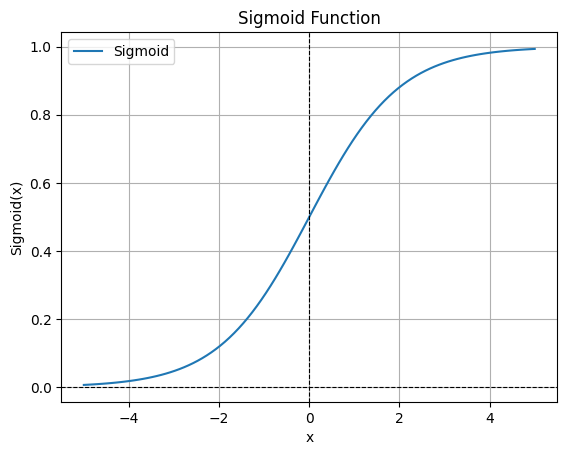

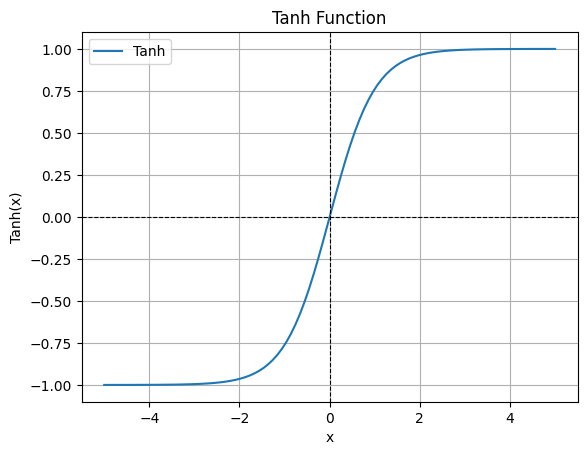

In [7]:
# making a graphical representation of a different activation functions

# def relu(x):
#     return np.maximum(0, x)

# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# def tanh(x):
#     return np.tanh(x)

plot_function(relu, 'ReLU')
plot_function(sigmoid, 'Sigmoid')
plot_function(tanh, 'Tanh')